<a href="https://colab.research.google.com/github/stemlock/w266_final_project/blob/master/Base_Model_Colab_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This workbook follows the example here: https://huggingface.co/transformers/custom_datasets.html?highlight=sequence#seq-imdb

Can download the data directly from Stanford website with the following two commands:
wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xf aclImdb_v1.tar.gz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/W266 Final Project/Code'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/W266 Final Project/Code


In [ ]:
# This only needs to be run once to install the transformers library
import os, sys
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/', nb_path)
sys.path.insert(0,nb_path)

!pip install --target=$nb_path transformers

In [3]:
!pip install transformers

In [21]:
# Imports
import os
import random

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

In [5]:
# Set random seed
seed = random.seed(42)

In [13]:
# # Preprocess data in script to create neutral and gendered versions
!python3 preprocess.py -d 'data/aclImdb/train/' -v 'wordlist/' -o 'data/processed_train.csv'
!python3 preprocess.py -d 'data/aclImdb/test/' -v 'wordlist/' -o 'data/processed_test.csv'

Parsing data...
Parsing vocab lists...
Creating vocab mappings...
Processing neutral review dataset...
Processing female gendered review dataset...
Processing male gendered review dataset...
Saved new dataset to /content/drive/My Drive/W266 Final Project/Code/data/processed_train.csv
Parsing data...
Parsing vocab lists...
Creating vocab mappings...
Processing neutral review dataset...
Processing female gendered review dataset...
Processing male gendered review dataset...
Saved new dataset to /content/drive/My Drive/W266 Final Project/Code/data/processed_test.csv


In [6]:
# Read in processed data
df_train = pd.read_csv('data/processed_train.csv')
df_test = pd.read_csv('data/processed_test.csv')
df_train.head()

,review_id,review_score,review_text,neutral_review_text,female_review_text,male_review_text,label
0,127,7,Zentropa has much in common with The Third Man...,zentropa has much in common with the third [UN...,zentropa has much in common with the third wom...,zentropa has much in common with the third man...,1
1,126,10,Zentropa is the most original movie I've seen ...,zentropa is the most original movie i've seen ...,zentropa is the most original movie i've seen ...,zentropa is the most original movie i've seen ...,1
2,125,7,Lars Von Trier is never backward in trying out...,lars von trier is never backward in trying out...,lars von trier is never backward in trying out...,lars von trier is never backward in trying out...,1
3,124,10,*Contains spoilers due to me having to describ...,*contains spoilers due to me having to describ...,*contains spoilers due to me having to describ...,*contains spoilers due to me having to describ...,1
4,123,10,That was the first thing that sprang to mind a...,that was the first thing that sprang to mind a...,that was the first thing that sprang to mind a...,that was the first thing that sprang to mind a...,1


In [7]:
# Check how many reviews had no replacement tokens
print("Nongendered revies in train:", df_train['neutral_review_text'].isna().sum())
print("Nongendered revies in test:", df_test['neutral_review_text'].isna().sum())

Nongendered revies in train: 4119
Nongendered revies in test: 4172


In [8]:
# Isolate the nongendered reviews 
df_nongendered = df_train[df_train['neutral_review_text'].isna()]

In [9]:
# Check the balance of review scores in the original train set
df_train['review_score'].value_counts()/len(df_train['review_score'])

1     0.20400
10    0.18928
8     0.12036
4     0.10784
7     0.09984
3     0.09680
2     0.09136
9     0.09052
Name: review_score, dtype: float64

In [10]:
# Check the balance of review scores in the nongendered reviews
df_nongendered['review_score'].value_counts()/len(df_nongendered['review_score'])

1     0.251517
10    0.237679
8     0.097354
9     0.092498
2     0.090070
4     0.088128
3     0.079145
7     0.063608
Name: review_score, dtype: float64

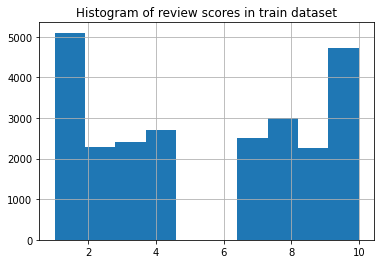

In [11]:
# Check the distribution of the review scores in train
df_train.hist(column='review_score')
plt.title("Histogram of review scores in train dataset")
plt.show()

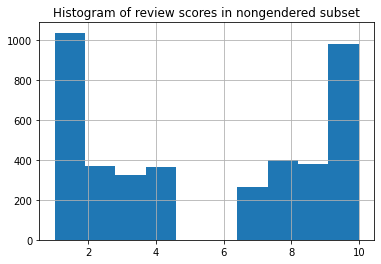

In [12]:
# Check the distribution of the review scores in nongendered reviews
df_nongendered.hist(column='review_score')
plt.title("Histogram of review scores in nongendered subset")
plt.show()

In [13]:
# Drop all nongendered rows in train
df_train.dropna(inplace=True)
print("Number of rows left in train:", df_train.shape[0])
print("Class balance:")
print(df_train['label'].value_counts())

Number of rows left in train: 20881
Class balance:
1    10477
0    10404
Name: label, dtype: int64


In [14]:
# Drop all nongendered rows in test
df_test.dropna(inplace=True)
print("Number of rows left in test:", df_test.shape[0])
print("Class balance:")
print(df_test['label'].value_counts())

Number of rows left in test: 20828
Class balance:
0    10471
1    10357
Name: label, dtype: int64


In [15]:
# Load data
train_texts = df_train['review_text'].values.tolist()
n_train_texts = df_train['neutral_review_text'].values.tolist()
f_train_texts = df_train['female_review_text'].values.tolist()
m_train_texts = df_train['male_review_text'].values.tolist()
train_labels = df_train['label'].values.tolist()

test_texts = df_test['review_text'].values.tolist()
n_test_texts = df_test['neutral_review_text'].values.tolist()
f_test_texts = df_test['female_review_text'].values.tolist()
m_test_texts = df_test['male_review_text'].values.tolist()
test_labels = df_test['label'].values.tolist()

In [16]:
# Create dev set from portion of train set
dev_texts, test_texts, _, _ = train_test_split(test_texts, test_labels, test_size=.5, random_state=seed)
n_dev_texts, n_test_texts, _, _ = train_test_split(n_test_texts, test_labels, test_size=.5, random_state=seed)
f_dev_texts, f_test_texts, _, _ = train_test_split(f_test_texts, test_labels, test_size=.5, random_state=seed)
m_dev_texts, m_test_texts, dev_labels, test_labels = train_test_split(m_test_texts, test_labels, 
                                                                        test_size=.5, random_state=seed)

In [17]:
# Specify tokenizer and apply to each dataset
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [28]:
# Turn encodings into datasets for easy batching
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
dev_dataset = tf.data.Dataset.from_tensor_slices((
    dict(dev_encodings),
    dev_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [29]:
# Initiliaze the TPU devices
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices:")
print(tf.config.list_logical_devices('TPU'))

# Create the distribution strategy for training on TPU cluster
tpu_strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.35.43.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.43.138:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:
[LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [31]:
# Create the model within each device scope
with tpu_strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer, loss=model.compute_loss)

history = model.fit(train_dataset.batch(16), validation_data=dev_dataset.batch(16), epochs=10, batch_size=16, shuffle=True)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int32>]


 125/1306 [=>............................] - ETA: 1:11 - loss: 0.0270

KeyboardInterrupt: ignored

In [ ]:
model.save_model("original_base_model")
tokenizer.save_pretrained("original_tokenizer")